# Effect of initial SOC in dvdq

Study the effect of initial starting SOC on dvdq peak height and position

3/21/2025

In [1]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import pybamm

## Simple simulation

Let's set up a simple simulation. The arguments into the simulation are the model, which we will use the standard DFN for; the parameter set, which we will use the "Chen2020" parameter set; the experiment, i.e., a current or power profile; and the numerical solver.

In [19]:
NOM_CAPACITY = 5 # Ah

Mean power: 0.93 W
Discharge energy: 19.06 Wh


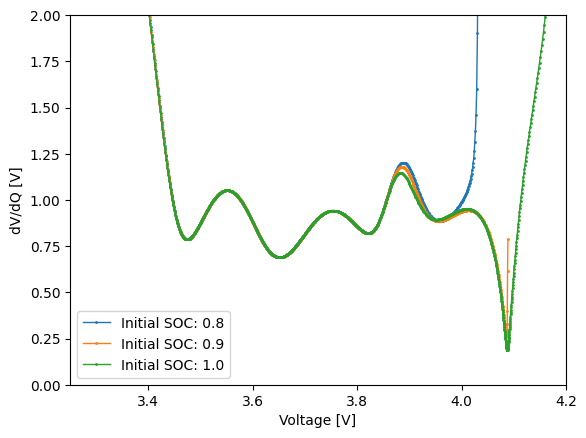

In [21]:
model = pybamm.lithium_ion.MPM()

params = pybamm.ParameterValues("Chen2020")

# Extract the radii values. We will choose these to be the means of our area-weighted distributions
R_a_n_dim = params["Negative particle radius [m]"]
R_a_p_dim = params["Positive particle radius [m]"]

# Standard deviations (dimensional)
sd_a_n_dim = 0.2 * R_a_n_dim
sd_a_p_dim = 0.6 * R_a_p_dim

# Minimum and maximum particle sizes (dimensional)
R_min_n = 0
R_min_p = 0
R_max_n = 2 * R_a_n_dim
R_max_p = 3 * R_a_p_dim

# Set the area-weighted particle-size distributions.
# Choose a lognormal (but any pybamm function could be used)


def f_a_dist_n_dim(R):
    return pybamm.lognormal(R, R_a_n_dim, sd_a_n_dim)


def f_a_dist_p_dim(R):
    return pybamm.lognormal(R, R_a_p_dim, sd_a_p_dim)


# Note: the only argument must be the particle size R
# input distribution params to the dictionary
distribution_params = {
    "Negative minimum particle radius [m]": R_min_n,
    "Positive minimum particle radius [m]": R_min_p,
    "Negative maximum particle radius [m]": R_max_n,
    "Positive maximum particle radius [m]": R_max_p,
    "Negative area-weighted " + "particle-size distribution [m-1]": f_a_dist_n_dim,
    "Positive area-weighted " + "particle-size distribution [m-1]": f_a_dist_p_dim,
}
params.update(distribution_params, check_already_exists=False)

experiment = pybamm.Experiment(
    ["Discharge at C/20 until 2.5V"]
    )

solver = pybamm.CasadiSolver(atol=1e-3, rtol=1e-3, mode="safe", dt_max=1)

sim = pybamm.Simulation(model=model,
                        parameter_values=params,
                        experiment=experiment,
                        solver=solver)

fig, ax = plt.subplots()

soc_vec = [0.8, 0.9, 1.0]
sol_vec = []

for soc_init in soc_vec:

    sol = sim.solve(initial_soc=soc_init)
    sol_vec.append(sol)

    time = sol["Time [s]"].data
    power = sol["Power [W]"].data
    voltage = sol["Voltage [V]"].data
    energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
    current = sol["Current [A]"].data

    capacity = np.cumsum(current * np.diff(np.append(0, time))) / 3600
    soc = 1 - capacity/NOM_CAPACITY
    dvdq = np.gradient(voltage)/np.gradient(soc)

    ax.plot(voltage, dvdq, 'o-', linewidth=1, markersize=1, label=f"Initial SOC: {soc_init}")

ax.set_xlabel("Voltage [V]")
ax.set_ylabel("dV/dQ [V]")
ax.set_ylim((0,2))
ax.set_xlim((3.25, 4.2))
ax.legend()
print(f"Mean power: {np.mean(power):.2f} W")
print(f"Discharge energy: {energy[-1]:.2f} Wh")



When the simulation completes, let's look at the voltage response and calculate the cell energy and mean power.

Mean power: 19.35 W
Discharge energy: 17.56 Wh


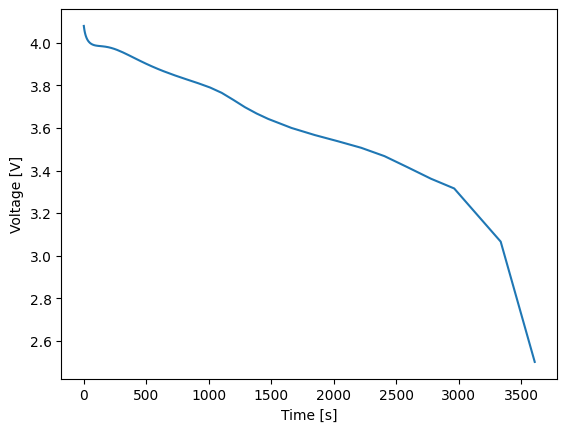

## Sweeping C-rate

By sweeping the C-rate, we can see how the power and energy change (higher C-rate means higher power and lower energy).

In [4]:
C_rates = [0.1, 0.2, 0.5, 0.75, 1, 1.5, 2, 2.25, 2.5, 3, 3.5, 4, 5, 7.5, 10]

def sweep_c_rate(C_rates, parameter_values):
    """
    Simulates battery discharge at different C-rates and collects performance metrics.

    Parameters
    ----------
    C_rates : array-like
        List or array of C-rates to simulate discharge at
    parameter_values : pybamm.ParameterValues
        Battery model parameters

    Returns
    -------
    dict
        Dictionary containing simulation results with keys:
        - 'C-rate': Input C-rates
        - 'Energy [Wh]': Energy profiles over time for each C-rate
        - 'Discharge Energy [Wh]': Total discharge energy for each C-rate
        - 'Time [s]': Time points for each simulation
        - 'Voltage [V]': Voltage profiles over time for each C-rate
        - 'Mean Power [W]': Average power for each C-rate

    Notes
    -----
    Uses PyBaMM to simulate battery discharge from full charge (SOC=1)
    until reaching cutoff voltage of 2.5V at specified C-rates.
    Energy is calculated by integrating power over time.
    """

    outputs = {
            "C-rate": C_rates,
            "Energy [Wh]": [],
            "Discharge Energy [Wh]": [],
            "Time [s]": [],
            "Voltage [V]": [],
            "Mean Power [W]": []
            }

    for C_rate in C_rates:

        experiment = pybamm.Experiment(
            [f"Discharge at {C_rate}C until 2.5V"]
            )

        sim = pybamm.Simulation(model,
                                parameter_values=parameter_values,
                                experiment=experiment,
                                solver=solver
                                )

        sol = sim.solve(initial_soc=1)

        time = sol["Time [s]"].data
        power = sol["Power [W]"].data
        voltage = sol["Voltage [V]"].data

        energy = np.cumsum(power * np.diff(np.append(0, time))) / 3600
        discharge_energy = energy[-1]

        outputs["Voltage [V]"].append(voltage)
        outputs["Time [s]"].append(time)
        outputs["Energy [Wh]"].append(energy)
        outputs["Discharge Energy [Wh]"].append(discharge_energy)
        outputs["Mean Power [W]"].append(np.mean(power))

    return outputs

outputs_energy_cell = sweep_c_rate(C_rates, parameter_values)

In [ ]:
def plot_power_vs_energy(outputs):
    """
    Plot power and energy outputs versus C-rate with dual y-axes.
    This function creates a dual y-axis plot showing the relationship between:
    1. Discharge energy (left y-axis, red)
    2. Mean power (right y-axis, blue)
    versus C-rate (x-axis)

    Parameters
    ----------
    outputs : dict
        Dictionary containing the following keys:
        - "C-rate": array-like, C-rates for x-axis
        - "Discharge Energy [Wh]": array-like, energy values in Watt-hours
        - "Mean Power [W]": array-like, power values in Watts

    Returns
    -------
    tuple
        (fig, ax) where:
        - fig : matplotlib.figure.Figure
            The created figure object
        - ax : matplotlib.axes.Axes
            The primary axes object (energy axis)

    """

    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    ax.set_xlabel("C-rate")

    ax.plot(outputs["C-rate"], outputs["Discharge Energy [Wh]"], "-o", color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")
    ax.set_ylim(0, outputs["Discharge Energy [Wh]"][0] * 1.1)

    # add a twin axis for time on a log scale
    ax2.plot(outputs["C-rate"], outputs["Mean Power [W]"], "-o", color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Mean Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])
    ax2.set_ylim(0, outputs["Mean Power [W]"][-1] * 1.1)

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_power_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


In [ ]:
def plot_voltage_vs_energy(outputs):
    """
    Plot voltage vs energy curves from battery data.

    Args:
        outputs (dict): Dictionary containing voltage and energy data with keys:
            - "Voltage [V]": List/array of voltage values
            - "Energy [Wh]": List/array of energy values

    Returns:
        tuple: Contains:
            - fig (matplotlib.figure.Figure): The generated figure object
            - ax (matplotlib.axes.Axes): The axes object containing the plot

    """


    fig, ax = plt.subplots()

    for voltage, energy in zip(outputs["Voltage [V]"], outputs["Energy [Wh]"]):
        ax.plot(energy, voltage)
    ax.set_xlabel("Energy [Wh]")
    ax.set_ylabel("Voltage [V]")

    ax.grid(alpha=0.5)

    return fig, ax

fig, ax = plot_voltage_vs_energy(outputs_energy_cell)
fig.suptitle("Energy cell")


This is an energy cell with a maximum C-rate of 2C, so the energy drops off significantly as the C-rate increases above 2C

## Changing electrode thickness

We can also sweep the electrode thickness to see how the power and energy change. We will change the thickness of the positive electrode and the negative electrode proportionally to avoid having to change the N/P ratio and electrode balance.

In [ ]:
parameter_values_power_cell = pybamm.ParameterValues("Chen2020")
parameter_values_power_cell["Negative electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Positive electrode thickness [m]"] *= 1/2
parameter_values_power_cell["Electrode height [m]"] *= 2

outputs_power_cell = sweep_c_rate(C_rates, parameter_values_power_cell)
fig, ax = plot_power_vs_energy(outputs_power_cell)
fig.suptitle("Power cell")


The power cell maintains its capacity better at higher C-rates. The downside of the power cell is that it has a lower specific energy since the ratio of active material to inactive material (current collector, separator, etc.) is higher. PyBaMM does not provide a specific energy / specific power, so you would need to define your own function for how cell mass depends on parameters to get specific energy and specific power.

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_xlabel("C-rate")

styles = ["-o", "-x"]

for outputs, style in zip([outputs_energy_cell, outputs_power_cell], styles):

    ax.plot(outputs["C-rate"], outputs["Discharge Energy [Wh]"], style, color="tab:red")
    ax.set_ylabel("Energy [Wh]", color="tab:red")
    ax.tick_params(axis="y", labelcolor="tab:red")

    ax2.plot(outputs["C-rate"], outputs["Mean Power [W]"], style, color="tab:blue")
    ax2.tick_params(axis="y", labelcolor="tab:blue")
    ax2.set_ylabel("Mean Power [W]", color="tab:blue")
    ax2.set_xlim(0, outputs["C-rate"][-1])

ax.grid(alpha=0.5)

fig.suptitle("Energy cell (o) vs Power cell (x)");
